# Brain decoding with MLP

## Multilayer Perceptron
```{figure} mlp_decoding/multilayer-perceptron.png
---
width: 800px
name: multilayer-perceptron-fig
---
A multilayer perceptron with 25 units on the input layer, a single hidden layer with 17 units, and an output layer with 9 units. Figure generated with the [NN-SVG](http://alexlenail.me/NN-SVG/index.html) tool by [Alexander Lenail]. The figure is shared under a [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.
```
We are going to train a Multilayer Perceptron (MLP) classifier for brain decoding on the Haxby dataset. MLPs are one of the most basic architecture of artificial neural networks. MLPs consist of input and output layers as well as hidden layers that transform the input to the usable data for the output layer. Like other machine learning models for supervised learning, a MLP initially goes through a training phase. During this supervised phase, the network is taught what to look for and what is the desired output.
In this tutorial, we are going to train the simplest MLP architecture featuring one input layer, one output layer and just one hidden layer.

## Getting the data
We are going to download the dataset from Haxby and colleagues (2001) {cite:p}`Haxby2001-vt`. You can check section {ref}`haxby-dataset` for more details on that dataset. Here we are going to quickly download it, and prepare it for machine learning applications with a set of predictive variable, the brain time series `X`, and a dependent variable, the annotation on cognition `y`.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/home/pbellec/env/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Let's check the size of `X` and `y`:

In [2]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


So we have 1452 time points, with one cognitive annotations each, and for each time point we have recordings of fMRI activity across 675 voxels. We can also see that the cognitive annotations span 9 different categories.

We are going to use Keras for training the MLP, and we are going to convert the string categories into a one-hot encoder:

In [3]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
enc = OneHotEncoder(handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1))
# turn the sparse matrix into a pandas dataframe
y = pd.DataFrame(y_onehot.toarray())
display(y)

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1447,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Training a model
We are going to start by splitting our dataset between train and test. We will keep 20% of the time points as test, and then set up a 10 fold cross validation for training/validation.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

Now we can build a MLP using Tensorflow and Keras:

In [5]:
from keras.models import Sequential
from keras.layers import Dense

# number of unique conditions that we have
model_mlp = Sequential()

# Adding the input layer and the first hidden layer
model_mlp.add(Dense(50 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

# Adding the second hidden layer
model_mlp.add(Dense(30, kernel_initializer="uniform", activation = 'relu'))

# Using softmax at the end, length of categories shows the number of labels we have
model_mlp.add(Dense(len(categories), activation = 'softmax'))

model_mlp.summary()

2021-11-26 01:10:56.613990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/minc/1.9.18/lib:/opt/minc/1.9.18/lib/InsightToolkit
2021-11-26 01:10:56.614005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                33800     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 279       
Total params: 35,609
Trainable params: 35,609
Non-trainable params: 0
_________________________________________________________________


2021-11-26 01:10:57.296745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/minc/1.9.18/lib:/opt/minc/1.9.18/lib/InsightToolkit
2021-11-26 01:10:57.296760: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-26 01:10:57.296770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (system76-pc): /proc/driver/nvidia/version does not exist
2021-11-26 01:10:57.296897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time to train that model!

In [6]:
# Compiling the model
model_mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Fitting the model on the Training set
history = model_mlp.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

2021-11-26 01:10:57.355210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


 1/93 [..............................] - ETA: 19s - loss: 2.2234 - accuracy: 0.1000

93/93 [==============================] - 0s 2ms/step - loss: 1.6353 - accuracy: 0.4558 - val_loss: 1.4560 - val_accuracy: 0.5193


Epoch 2/10
 1/93 [..............................] - ETA: 0s - loss: 1.2157 - accuracy: 0.7000

93/93 [==============================] - 0s 643us/step - loss: 1.0738 - accuracy: 0.6304 - val_loss: 1.1770 - val_accuracy: 0.6094


Epoch 3/10
 1/93 [..............................] - ETA: 0s - loss: 1.0978 - accuracy: 0.7000

93/93 [==============================] - 0s 649us/step - loss: 0.7655 - accuracy: 0.7619 - val_loss: 0.9730 - val_accuracy: 0.6867


Epoch 4/10
 1/93 [..............................] - ETA: 0s - loss: 0.6723 - accuracy: 0.8000

93/93 [==============================] - 0s 672us/step - loss: 0.5411 - accuracy: 0.8351 - val_loss: 0.8672 - val_accuracy: 0.7039


Epoch 5/10
 1/93 [..............................] - ETA: 0s - loss: 0.4303 - accuracy: 0.8000

93/93 [==============================] - 0s 658us/step - loss: 0.3360 - accuracy: 0.9030 - val_loss: 0.8583 - val_accuracy: 0.7124


Epoch 6/10
 1/93 [..............................] - ETA: 0s - loss: 0.0851 - accuracy: 1.0000

93/93 [==============================] - 0s 698us/step - loss: 0.2107 - accuracy: 0.9494 - val_loss: 0.8599 - val_accuracy: 0.7167


Epoch 7/10
 1/93 [..............................] - ETA: 0s - loss: 0.1799 - accuracy: 0.9000

93/93 [==============================] - 0s 656us/step - loss: 0.1286 - accuracy: 0.9784 - val_loss: 0.7584 - val_accuracy: 0.7811


Epoch 8/10
 1/93 [..............................] - ETA: 0s - loss: 0.0463 - accuracy: 1.0000

93/93 [==============================] - 0s 656us/step - loss: 0.0732 - accuracy: 0.9935 - val_loss: 0.8167 - val_accuracy: 0.7854


Epoch 9/10
 1/93 [..............................] - ETA: 0s - loss: 0.0334 - accuracy: 1.0000

93/93 [==============================] - 0s 645us/step - loss: 0.0448 - accuracy: 0.9978 - val_loss: 0.8125 - val_accuracy: 0.7725


Epoch 10/10
 1/93 [..............................] - ETA: 0s - loss: 0.0237 - accuracy: 1.0000

93/93 [==============================] - 0s 695us/step - loss: 0.0248 - accuracy: 0.9989 - val_loss: 0.8638 - val_accuracy: 0.7639


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


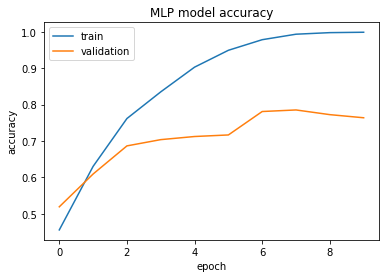

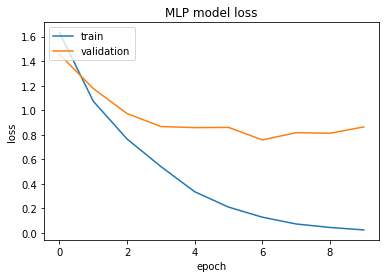

In [7]:
import sys
sys.path.append('../src')
import visualization
plot_history = visualization.classifier_history (history, 'MLP ')

## Assessing performance
Let's check the accuracy of the prediction on the training set:

In [8]:
# Making the predictions and evaluating the model
from sklearn.metrics import classification_report
y_train_pred = model_mlp.predict(X_train)
print(classification_report(y_train.values.argmax(axis = 1), y_train_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        85
           1       0.94      0.95      0.95        88
           2       0.97      0.87      0.92        90
           3       0.96      0.96      0.96        81
           4       1.00      0.97      0.98        91
           5       0.97      0.98      0.98       471
           6       0.88      0.94      0.91        81
           7       0.97      0.98      0.97        90
           8       0.90      0.86      0.88        84

    accuracy                           0.95      1161
   macro avg       0.94      0.94      0.94      1161
weighted avg       0.95      0.95      0.95      1161



This is dangerously high. Let's check on the test set:

In [9]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.87      0.73        23
           1       0.74      0.70      0.72        20
           2       0.67      0.67      0.67        18
           3       0.90      0.96      0.93        27
           4       0.87      0.76      0.81        17
           5       0.90      0.88      0.89       117
           6       0.67      0.67      0.67        27
           7       0.94      0.83      0.88        18
           8       0.67      0.58      0.62        24

    accuracy                           0.81       291
   macro avg       0.77      0.77      0.77       291
weighted avg       0.81      0.81      0.81       291



We can have a look at the confusion matrix:

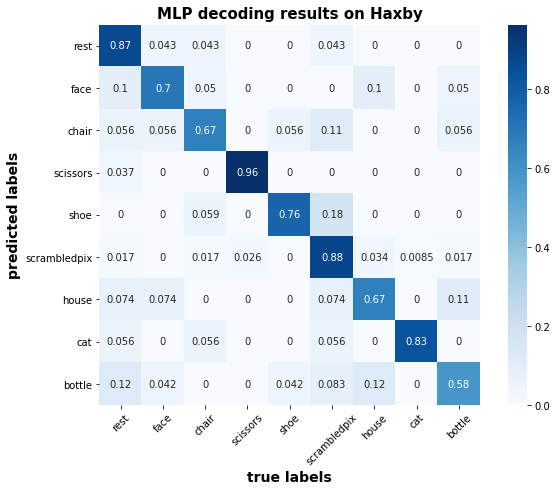

In [10]:
# confusion matrix
import sys
import numpy as np
from sklearn.metrics import confusion_matrix
sys.path.append('../src')
import visualization
cm_svm = confusion_matrix(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1))
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix,
                          categories,
                          title='MLP decoding results on Haxby')

```{warning}
Unfortunately we don't have a simple way to visualize the important features like we did with the linear SVM! You can check this fantastic [distill article](https://distill.pub/2017/feature-visualization/) to learn more about feature visualization in artificial neural networks.
```

## Exercises
 * What is the most difficult category to decode? Why?
 * The model seemed to overfit. Try adding a `Dropout` layer to regularize the model. You can read about dropout in keras in this [blog post](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab).
 * Try to add layers or hidden units, and observe the impact on overfitting and training time.